# EDA: enwiki denormalized edit history data dump

In [26]:
import os
import pandas as pd
from pathlib import Path

In [27]:
# Use the notebooks directory containing this notebook as working directory
home_path = str(Path.home())
os.chdir(home_path + '/git/predwikt/notebooks')

### Get the .tsv dump metadata

In [28]:
# Get the schema description
schema_df = pd.read_csv('../data/external/mediawiki_history_schema.tsv', delimiter='\t')

# Pull the mediawiki-edit-history column names from the data description, ignoring the last column
mw_hist_colnames = list(schema_df.col_name)[:-1]

# Explanation of why we ignore the last column 'snapshot':
print(schema_df.loc[schema_df.col_name == 'snapshot', 'comment'].values[0])

Versioning information to keep multiple datasets (YYYY-MM for regular labs imports). This field is the only one that is not present in the dumps version of the data set, because it is implied in the file URL.


### Select the shortlist of columns to pull from the dataset

**"Important Fields"**
"Due to the denormalization of the history data, filtering by event_entity is mandatory not to mix incompatible data.
Similarly, event_types filtering can/must be used depending of the analysis."

<div>
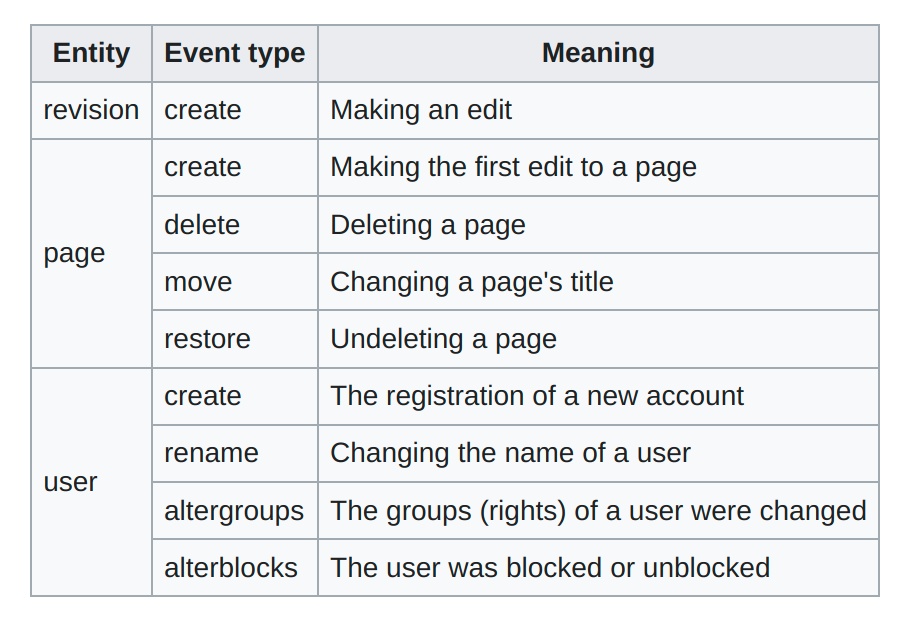
</div>

In [29]:
relevant_cols = ['event_entity', 'event_type', 'event_timestamp', 
            'event_user_id', 'event_user_text_historical', 'event_user_is_bot_by_historical',
            'page_id', 'page_title_historical', 'page_namespace_is_content_historical',
            'page_revision_count', 'revision_id', 'revision_parent_id', 
            'revision_text_bytes', 'revision_text_bytes_diff', 'revision_content_model',
            'revision_content_format']

In [30]:
usecols = ['event_entity', 'event_type', 'event_timestamp', 
           'event_user_is_bot_by_historical', 'revision_id',
           'revision_text_bytes', 'revision_text_bytes_diff']

### Import to pandas dataframe from tsv

Also, only keep "revision" edits, and remove bot edits.

In [31]:
df = pd.read_csv('../data/raw/2021-10.enwiki.2021-10.tsv', 
                 delimiter='\t', names=mw_hist_colnames, header=None, usecols=usecols,
                 nrows=100000) # 
df = df[df.event_user_is_bot_by_historical.isna()]
df = df[df.event_entity.isin(['revision'])]

df.shape

(60646, 7)

### Check that sample doesn't contain bot edits

I didn't find it stated explicitly, but I think:
- If a user account had the "bot" user-right/user-property, then it shows result "group" in this field.
- If the username ended with "bot", it is shows result "name" in this field. [link](https://en.wikipedia.org/wiki/Wikipedia:Bot_policy#Bot_accounts)

In [32]:
df.event_user_is_bot_by_historical.value_counts()

Series([], Name: event_user_is_bot_by_historical, dtype: int64)

### Explore frequency of values in some columns

In [33]:
df.set_index(['event_entity','event_type']).index.value_counts()

(revision, create)    60646
dtype: int64

In [34]:
df.revision_id.value_counts().value_counts()

1    60646
Name: revision_id, dtype: int64

In [35]:
df.revision_parent_id.value_counts().value_counts()

AttributeError: 'DataFrame' object has no attribute 'revision_parent_id'

In [ ]:
57256 + 3390

**"Important Fields" Frequency Analysis**
- 90,187 total revisions
    - 86,628 unique revision_parent_id's
    - 3559 revision_parent_id's equalling 1

In [ ]:
df.page_id.value_counts().value_counts().head(5)

In [ ]:
df.page_id.value_counts().value_counts().tail(5)

In [ ]:
df.groupby('event_entity').apply(lambda x: x.page_id.notnull().sum())

**page_id Frequency Analysis**
- Half of edits are on pages that only got one edit the whole time